# Fetching observations from MET data base services

This notebook serves as sandbox for fetching data from frost.met, havvarsel-frost.met and thredds.met

See https://api.met.no/ for all interfaces and possible sources!!


## Havvarsel frost
Havvarsel frost delivers so far `temperature` measurements originated from badevann.no at seven beaches in the south of Norway (glider data integrated in the meantime, but not yet used here!). 
> Documentation:
> - API documentation for obs/badevann https://havvarsel-frost.met.no/docs/apiref#/obs%2Fbadevann/obsBadevannGet 
> - Datastructure described on https://havvarsel-frost.met.no/docs/dataset_badevann




In [1]:
# Importing general libraries
import sys
import json
import datetime
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Example to fetch time series

In [2]:
start_time = datetime.datetime.strptime("2021-10-01T00:00", "%Y-%m-%dT%H:%M")
end_time = datetime.datetime.strptime("2021-11-01T00:00", "%Y-%m-%dT%H:%M")


In [3]:
frost_api_base="https://havvarsel-frost.met.no"
endpoint = frost_api_base + "/api/v1/obs/badevann/get"

payload = {'time': str(start_time.isoformat()) + "Z/" + str(end_time.isoformat()) + "Z", 
                    'incobs':'true', 'buoyids': 100, 'parameter':'temperature'}
# the havvarsel-frost API uses colon in the url and does not replace them with ASCI what is default
payload_str = "&".join("%s=%s" % (k,v) for k,v in payload.items())

In [4]:
try:
    r = requests.get(endpoint, params=payload_str)
    print("Trying " + r.url)
    r.raise_for_status()
except requests.exceptions.HTTPError as err:
    raise Exception(err)


Trying https://havvarsel-frost.met.no/api/v1/obs/badevann/get?time=2021-10-01T00:00:00Z/2021-11-01T00:00:00Z&incobs=true&buoyids=100&parameter=temperature


### Explore available data

In [5]:
badevann_df = pd.DataFrame(columns=['buoyid', 'name', 'lat', 'lon'])

for id in range(150):
    try:
        payload = {'time': str(start_time.isoformat()) + "Z/" + str(end_time.isoformat()) + "Z", 
                    'incobs':'true', 'buoyids': id}
        payload_str = "&".join("%s=%s" % (k,v) for k,v in payload.items())
        r = requests.get(endpoint, params=payload_str)
        
        name = r.json()["data"]["tseries"][0]["header"]["extra"]["name"]
        lat = r.json()["data"]["tseries"][0]["header"]["extra"]["pos"]["lat"]
        lon = r.json()["data"]["tseries"][0]["header"]["extra"]["pos"]["lon"]
        badevann_df = badevann_df.append({"buoyid" : id, "name" : name, "lat" : lat, "lon" : lon}, ignore_index=True)
    except:
        pass

In [6]:
badevann_df

,buoyid,name,lat,lon
0,5,Aksdalsvatnet,59.416750,5.418333
1,7,Grønnavigå,58.988380,5.739830
2,10,Sjøbadet,63.435770,10.390610
3,11,Munkholmen,63.451380,10.384790
4,13,Vaulen,58.926347,5.750357
...,...,...,...,...
64,128,Volsdalsberga,62.467929,6.198442
65,129,Sandnessjøen havsbad,65.989325,12.623672
66,130,Mosvatnet,59.420210,6.447400
67,131,Våge,60.044350,5.524630


In [7]:
badevann_df.to_csv("badevann-buoys.csv", sep=" ", index=False)

In [8]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
norway = world[world["name"]=="Norway"]

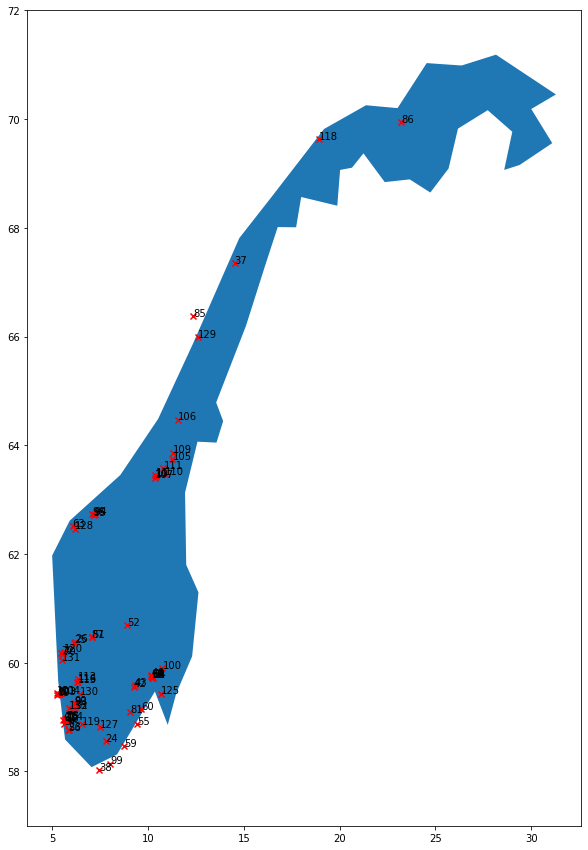

In [14]:
lon = np.array(badevann_df["lon"],dtype=float)
lat = np.array(badevann_df["lat"],dtype=float)
buoyid = np.array(badevann_df["buoyid"],dtype=int)

fig, ax = plt.subplots(1,1,figsize=(10,15))
bg = norway.plot(ax=ax)
ax.set_ylim((57,72))

ax.scatter(np.array(badevann_df["lon"],dtype=float), np.array(badevann_df["lat"],dtype=float), c="red", marker="x")
for i, txt in enumerate(buoyid):
    ax.annotate(str(txt), (lon[i], lat[i]))